In [1]:
import os

# Import Environment Variables
def set_tokens():
    global HUGGINGFACEHUB_API_TOKEN
    global GROQ_API_KEY
  
    if os.getenv("HUGGINGFACEHUB_API_TOKEN") is not None:
        HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
        print(f"Token is added")
    if os.getenv("GROQ_API_KEY") is not None:
        GROQ_API_KEY = os.environ["GROQ_API_KEY"]
    if (os.getenv("AZURE_OPENAI_ENDPOINT") is not None 
            or os.getenv("AZURE_OPENAI_API_KEY") is not None):
        AZURE_OPENAI_ENDPOINT = os.environ["AZURE_OPENAI_ENDPOINT"]
        AZUER_OPENAI_API_KEY = os.environ["AZURE_OPENAI_API_KEY"]
    else:
        raise Exception("No API Token Provided!")


set_tokens()

Token is added


### Create Agents
The following helper functions will help create agents. These agents will then be nodes in the graph.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Define tools
We will also define some tools that our agents will use in the future

In [3]:


from typing import Annotated

# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
# from langchain_experimental.utilities import PythonREPL

# tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

# repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # result = repl.run(code)
        result = "There is no snow in the desert."
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

#### Create graph
Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

#### Define State
We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [4]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes
We now need to define the nodes. First, let's define the nodes for the agents.

In [5]:
import functools

from langchain_core.messages import AIMessage
from langchain_groq import ChatGroq


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatGroq(model="llama-3.2-3b-preview", api_key=GROQ_API_KEY)

# Research agent and node
research_agent = create_agent(
    llm,
    [], # Add tools in here
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

Define Tool Node \
We now define a node to run the tools

In [6]:
from langgraph.prebuilt import ToolNode

tools = [] # tavily_tool, python_repl
tool_node = ToolNode(tools)

Define Edge Logic \
We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [7]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

Define the Graph \
We can now put it all together and define the graph!

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

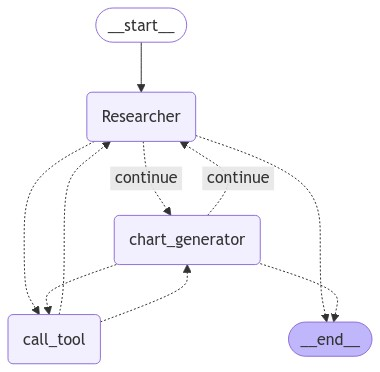

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Invoke
With the graph created, you can invoke it! Let's have it chart some stats for us.

In [10]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='I\'ll use Python and the pandas library to fetch the UK\'s GDP data and matplotlib to draw a line graph.\n\n**Fetching Data**\n\nUnfortunately, I\'m a large language model, I don\'t have direct access to real-time data. However, I can use historical data available online. According to the Office for National Statistics (ONS), the UK\'s GDP data is available on their website. I\'ll use the data from 2018 to 2022.\n\nHere\'s a Python code snippet to fetch the data:\n\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# URL for the UK\'s GDP data\nurl = "https://www.ons.gov.uk/peoplepopulationandcommunity/economy/national-accounts/datasets/gross-domestic-product-gdp"\n\n# Fetch the data\ndata = pd.read_html(url)\ngdp_data = data[0]\n\n# Extract the relevant columns\ngdp_data.columns = [\'Year\', \'GDP (£m)\']\n\n# Convert the \'GDP (£m)\' column to float\ngdp_data[\'GDP (£m)\'] = gdp_data[\'GDP (£m)\'].astype(float)\n\n# Sel